# OVERVIEW

This iPython Notebook uses the **_Boston Housing_** data set to illustrate

- **Decision Trees** and trees-related **_ensemble modeling_** methods:
- **Random Forests**, which are based on **Bootstrap Aggregating** ("**Bagging**") applied to trees; and 
- **Boosted Additive (Trees) Models**.

# _first, some boring logistics..._

Let's first:

- install and import some necessary Python packages and helper modules; and
- set some constants.

In [1]:
# enable in-line MatPlotLib
%matplotlib inline

In [2]:
# import Python packages
from __future__ import division, print_function
import ggplot
import matplotlib
from matplotlib import pyplot
import multiprocessing
import numpy
import os
import pandas
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
# set CONSTANTS

# in AWS EMR mode?
AWS_EMR_MODE = os.path.expanduser('~') == '/home/hadoop'

# data paths
DATA_FILE_NAME = 'BostonHousing.csv'
DATA_URL = 'https://raw.githubusercontent.com/ChicagoBoothML/DATA___BostonHousing/master/%s' % DATA_FILE_NAME

# number of examples to show from a data set
NB_EXAMPLES_TO_SHOW = 9

# random seed
RANDOM_SEED = 99

In [4]:
# install ChicagoBoothML_Helpy package
CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND = \
    'pip install --upgrade git+git://GitHub.com/ChicagoBoothML/Helpy --no-dependencies'
    
if AWS_EMR_MODE:
    os.system('sudo %s' % CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND)
else:
    os.system(CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND)

In [5]:
# import from ChicagoBoothML_Helpy
from ChicagoBoothML_Helpy.EvaluationMetrics import mse

# Boston Housing data set

Let's now import the Boston Housing data into a **`pandas`** data frame:

In [6]:
# read Boston Housing data into data frame
boston_housing_df = pandas.read_csv(DATA_URL)

boston_housing_df.sort_values(by='lstat', inplace=True)
nb_samples = len(boston_housing_df)
boston_housing_df[:NB_EXAMPLES_TO_SHOW]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
161,1.46336,0,19.58,0,0.6050,7.489,90.8,1.9709,5,403,14.7,374.43,1.73,50.0
162,1.83377,0,19.58,1,0.6050,7.802,98.2,2.0407,5,403,14.7,389.61,1.92,50.0
40,0.03359,75,2.95,0,0.4280,7.024,15.8,5.4011,3,252,18.3,395.62,1.98,34.9
232,0.57529,0,6.20,0,0.5070,8.337,73.3,3.8384,8,307,17.4,385.91,2.47,41.7
192,0.08664,45,3.44,0,0.4370,7.178,26.3,6.4798,5,398,15.2,390.49,2.87,36.4
204,0.02009,95,2.68,0,0.4161,8.034,31.9,5.1180,4,224,14.7,390.55,2.88,50.0
3,0.03237,0,2.18,0,0.4580,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
370,6.53876,0,18.10,1,0.6310,7.016,97.5,1.2024,24,666,20.2,392.05,2.96,50.0
195,0.01381,80,0.46,0,0.4220,7.875,32.0,5.6484,4,255,14.4,394.23,2.97,50.0


# Models with 1 Predictor

For illustrative purposes, let's look at two variables of interest: **`lstat`** (our predictor variable(s) $\mathbf X$) and **`medv`** (our variable to predict $\mathbf y$). Below is a plot of them against each other:

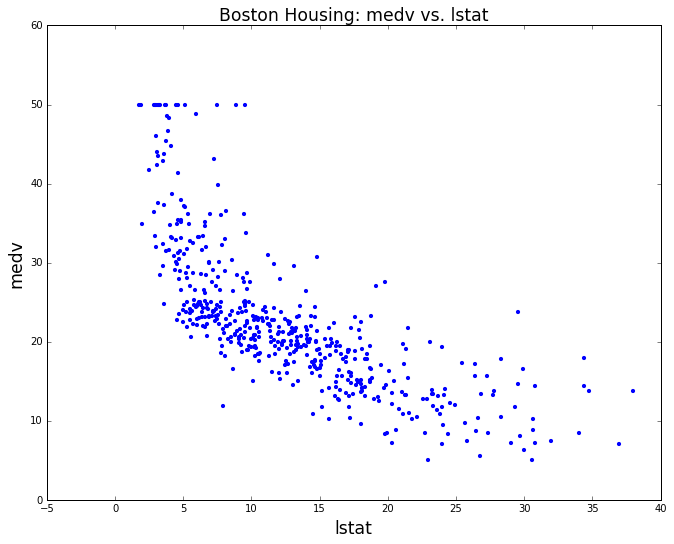

<ggplot: (8726899733741)>

In [7]:
# set PyPlot parameters
pyplot.rcParams['axes.titlesize'] = 'xx-large'   # font size for plot title

# plotting function for repeated calls
def plot_boston_housing_data(
        boston_housing_data,
        x_name='lstat', y_name='medv', y_hat_name='predicted_medv',
        title='Boston Housing: medv vs. lstat',
        plot_predicted=True):
    
    g = ggplot.ggplot(
            ggplot.aes(
                x=x_name,
                y=y_name),
            data=boston_housing_data) + \
        ggplot.geom_point(
            size=10,
            color='blue') + \
        ggplot.ggtitle(title) + \
        ggplot.xlab(x_name) + ggplot.ylab(y_name) + \
        ggplot.theme_matplotlib(
            rc={'figure.figsize': (11, 8.5),
                'axes.labelsize': 'xx-large'},
            matplotlib_defaults=False)
        
    if plot_predicted:
        g += ggplot.geom_line(
            ggplot.aes(
                x=x_name,
                y=y_hat_name),
            size=2,
            color='darkorange')
    
    return g

plot_boston_housing_data(boston_housing_df, plot_predicted=False)

## Single Decision Trees

Let's now play with a few single decision trees, using all samples:

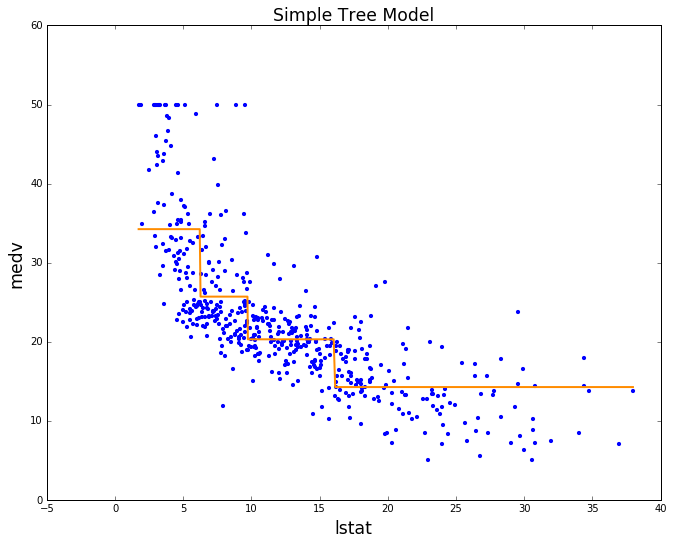

<ggplot: (8726868908221)>

In [8]:
tree_model = \
    DecisionTreeRegressor(
        criterion='mse',
        splitter='best',
        max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
        min_samples_split=200,
        min_samples_leaf=100,
        min_weight_fraction_leaf=0.0,
        max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
        max_leaf_nodes=None,   # None: unlimited number of leaf nodes
        random_state=RANDOM_SEED)

tree_model.fit(
    X=boston_housing_df[['lstat']],
    y=boston_housing_df.medv)

boston_housing_df['predicted_medv'] = \
    tree_model.predict(
        X=boston_housing_df[['lstat']])

plot_boston_housing_data(
    boston_housing_df,
    title='Simple Tree Model')

We see that with the above tuning parameters, the tree model is a **fairly simple, crude step function**. This function seems to have **high bias** and **low variance**.

Let's try bigger, more complex tree:

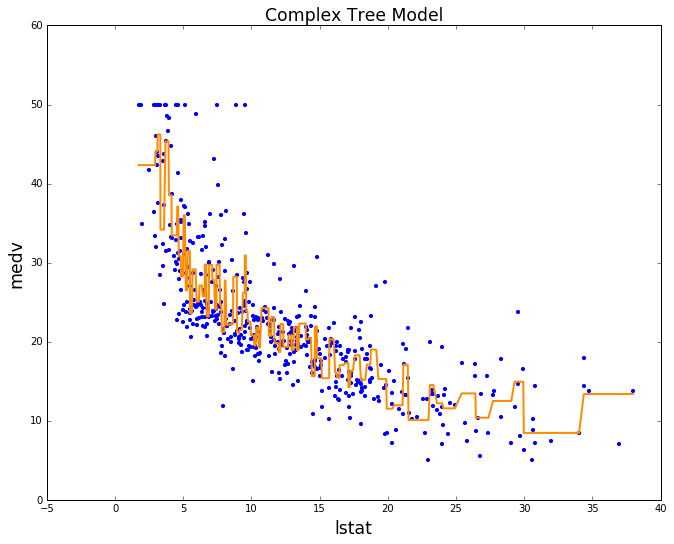

<ggplot: (8726868908213)>

In [9]:
tree_model = \
    DecisionTreeRegressor(
        criterion='mse',
        splitter='best',
        max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
        min_samples_split=10,
        min_samples_leaf=5,
        min_weight_fraction_leaf=0.0,
        max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
        max_leaf_nodes=None,   # None: unlimited number of leaf nodes
        random_state=RANDOM_SEED)

tree_model.fit(
    X=boston_housing_df[['lstat']],
    y=boston_housing_df.medv)

boston_housing_df['predicted_medv'] = \
    tree_model.predict(
        X=boston_housing_df[['lstat']])

plot_boston_housing_data(
    boston_housing_df,
    title='Complex Tree Model')

Now, with the new parameters, we have a more complex model that is **low-bias**, **high-variance**.

Fitting a good model with a single tree is difficult, largely because a single tree is fit using a greedy heuristic that may not be optimal in the first place.

In practice, trees are almost always used in an **ensemble modeling** manner. The computational inexpensiveness of individual trees allow numerous trees to be fitted in acceptable run times, and collected into an "ensemble" of fitted models, the predictions of which are combined in certain ways. Two prominent ensemble methods are **bagging** (**_bootstrap aggregating_**) and **boosting**.

## Bagging and Random Forests

With the [**bagging**](http://en.wikipedia.org/wiki/Bootstrap_aggregating) method, $B$ models of a certain kind (usually, but not necessarily, tree models) are fitted on $B$ bootstrap samples of the training data set, and their **predictions are averaged** to produce the ensemble prediction function.

- Each **individual model** among the $B$ model should be a **sufficiently-complex, low-bias** model &ndash; which also means that each individual model is likely to have **high variance**;
- The low bias of each model will result in an **average ensemble model that also has low bias**; and
- In order to make the ensemble model also have low variance, we select a large enough number $B$, so that individual models' high variances offset each other in the aggregate!

The application of "bagging" using tree models is called **Random Forest**:

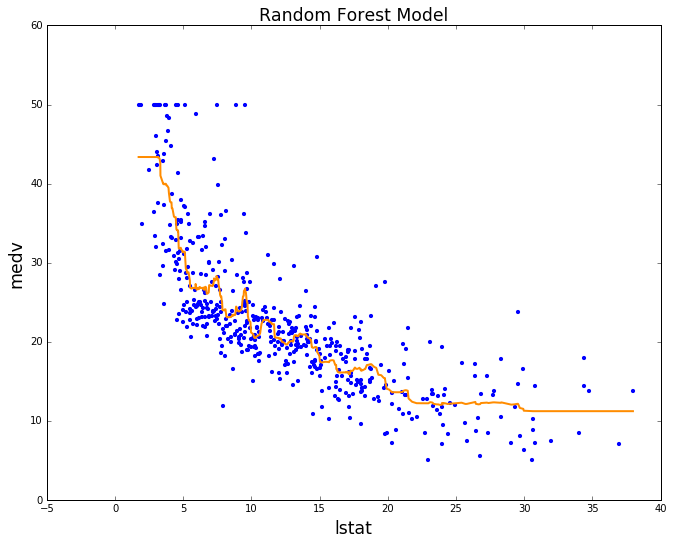

<ggplot: (8726851599089)>

In [10]:
B = 5000

rf_model = \
    RandomForestRegressor(
        n_estimators=B,
        criterion='mse',
        max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
        min_samples_split=20,
        min_samples_leaf=10,
        min_weight_fraction_leaf=0.0,
        max_features='auto',   # number of features to consider when looking for the best split; "auto": max_features=n_features
        max_leaf_nodes=None,   # None: unlimited number of leaf nodes
        bootstrap=True,
        oob_score=True,   # estimate Out-of-Bag RMSE
        n_jobs=multiprocessing.cpu_count() - 2,   # paralellize over all CPU cores but 2
        random_state=RANDOM_SEED,
        verbose=0,
        warm_start=False)

rf_model.fit(
    X=boston_housing_df[['lstat']],
    y=boston_housing_df.medv)

boston_housing_df['predicted_medv'] = \
    rf_model.predict(X=boston_housing_df[['lstat']])

plot_boston_housing_data(
    boston_housing_df,
    title='Random Forest Model')

We can see that the average prediction of many trees in the Random Forest does well in capturing the signal in the data. We'd be reasonably happy with such a predictive model. The estimated Out-of-Bag (OOB) RMSE of this model is:

In [11]:
# note that the "oob_score_" provided by SciKit is the estimated Out-of-Bag R^2
# from R^2 we can derive a rough RMSE
numpy.sqrt(boston_housing_df['medv'].var() * (1 - rf_model.oob_score_))

5.3780027857772907

## Boosting

With the <a href="http://en.wikipedia.org/wiki/Boosting_(machine_learning)">**boosting**</a> method, we successively advance towards a good model fit by adding up small fractions / proportions of relatively simple models that have low variances but possibly high biases. The key intuition is as follows:

- Because individual models are simple and have low variance, the combined additive ensemble model is also likely to have low variance; and
- Because models are successively fit to capture the residuals left over from the previous models, models' biases are likely to offset each other, resulting in an additive ensemble model with low bias!

Let's now build a tree ensemble using boosting:

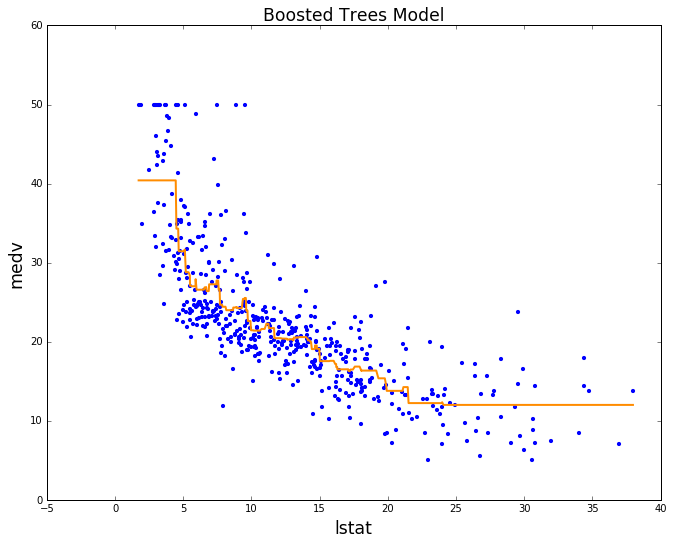

<ggplot: (8726851518633)>

In [12]:
boost_model = \
    GradientBoostingRegressor(
        n_estimators=B,
        loss='ls',   # Least-Squares objective loss function
        learning_rate=.001,   # shrinkage parameter
        subsample=1.0,
        min_samples_split=80,
        min_samples_leaf=40,
        min_weight_fraction_leaf=0.0,
        max_depth=10,   # maximum tree depth / number of levels of interaction
        init=None,
        random_state=RANDOM_SEED,
        max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
        alpha=.9,   # NOT RELEVANT for Least-Squares loss function
        verbose=0,
        max_leaf_nodes=None,   # None: unlimited number of leaf nodes
        warm_start=False)

boost_model.fit(
    X=boston_housing_df[['lstat']],
    y=boston_housing_df.medv)

boston_housing_df['predicted_medv'] = \
    boost_model.predict(
        X=boston_housing_df[['lstat']])

plot_boston_housing_data(
    boston_housing_df,
    title='Boosted Trees Model')

This Boosted Trees ensemble model also looks fair, and its OOS RSME can be estimated using Cross Validation as follows:

In [13]:
def mse_score(estimator, X, y):
    y_hat = estimator.predict(X)
    return mse(y_hat, y)

numpy.sqrt(
    cross_val_score(
        boost_model,
        X=boston_housing_df[['lstat']],
        y=boston_housing_df.medv,
        cv=KFold(n=nb_samples,
                 n_folds=5,   # 5-fold cross validation
                 shuffle=True),
        scoring=mse_score).mean())

5.3782091513995605

# Multivariate Models

Besides their computation inexpensiveness, another _huge_ advantage of using trees-based algorithms is that they are very scalable to multivariate models, and deals with variable interactions very nicely without the need of standard scaling.

Let's build multivariate Random Forest and Boosted Trees models to predict _medv_ using all other variables in the Boston Housing data set:

In [14]:
boston_housing_df.drop(
    'predicted_medv',
    axis=1,
    inplace=True)   # remove predicted values column

In [15]:
nb_columns = len(boston_housing_df.columns)
X_column_names = boston_housing_df.columns[:(nb_columns - 1)]

In [16]:
rf_model.fit(
    X=boston_housing_df[X_column_names],
    y=boston_housing_df.medv)

rf_predictions = \
    rf_model.predict(
        X=boston_housing_df[X_column_names])

The multivariate Random Forest has an estimated OOB RMSE of:

In [17]:
numpy.sqrt(boston_housing_df['medv'].var() * (1 - rf_model.oob_score_))

3.9317893583446653

which is clearly better than that of the univariate Random Forest model.

In [18]:
boost_model.fit(
    X=boston_housing_df[X_column_names],
    y=boston_housing_df.medv)

boost_predictions = \
    boost_model.predict(
        X=boston_housing_df[X_column_names])

The multivariate Boosted Trees model has an estimated Cross Validation-estimated OOS RMSE of:

In [19]:
numpy.sqrt(
    cross_val_score(
        boost_model,
        X=boston_housing_df[X_column_names],
        y=boston_housing_df.medv,
        cv=KFold(n=nb_samples,
                 n_folds=5,   # 5-fold cross validation
                 shuffle=True),
        scoring=mse_score).mean())

3.8014092481104038

again a clear improvement from the univariate Boosted Trees model.

We can also see that the two models' prediction are pretty aligned:

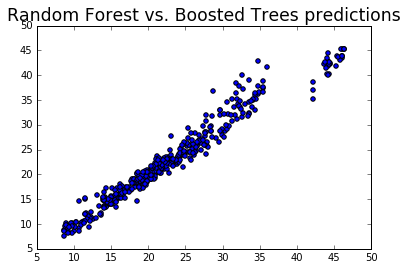

In [20]:
pyplot.scatter(
    x=rf_predictions,
    y=boost_predictions)

pyplot.title('Random Forest vs. Boosted Trees predictions')

The two models also agree on the most important variables:

In [21]:
feature_importances = \
    pandas.DataFrame(
        index=X_column_names)

feature_importances['RandomForest_VarImp'] = \
    rf_model.feature_importances_

feature_importances['BoostedTrees_VarImp'] = \
    boost_model.feature_importances_
    
feature_importances

,RandomForest_VarImp,BoostedTrees_VarImp
crim,0.028708,0.035551
zn,0.000464,0.000013
indus,0.002540,0.009487
chas,0.000030,0.000000
nox,0.016622,0.086986
rm,0.473038,0.224030
age,0.009487,0.033198
dis,0.015246,0.162538
rad,0.002399,0.015372
tax,0.005605,0.035650


# _BONUS:_ Apache Spark solution

The following uses Apache Spark to solve the same problem (pretending that the data were much larger)

In [22]:
# Apache Spark settings
if AWS_EMR_MODE:
    SPARK_MODE = 'yarn-client'                 # running Spark on AWS EMR YARN cluster
    SPARK_HOME = '/usr/lib/spark'              # default Spark installation folder on AWS EMR master node
    SPARK_DRIVER_MEMORY = '9g'                 # memory allocated to MapReduce driver process
    SPARK_EXECUTOR_MEMORY = '3g'               # memory allocated to each MapReduce executor process
    SPARK_DRIVER_MAX_RESULT_SIZE = '6g'        # maximum size of objects collected back to MapReduce driver process
else:
    SPARK_MODE = 'local'                       # running Spark on single machine
    SPARK_HOME = '/Applications/spark-1.5.2'   # Spark installation folder on my machine
    SPARK_DRIVER_MEMORY = '5g'                 # memory allocated to MapReduce driver process 
    SPARK_EXECUTOR_MEMORY = '1g'               # memory allocated to each MapReduce executor process
    SPARK_DRIVER_MAX_RESULT_SIZE = '3g'        # maximum size of objects collected back to MapReduce driver process

## Import PySpark and initialize SparkContext & HiveContext

In [23]:
if 'pyspark' not in vars():   # set up Apache Spark environment if not yet done so
    
    # set environment variables for Spark
    os.environ['SPARK_HOME'] = SPARK_HOME
    os.environ['SPARK_HIVE'] = 'true'
    
    # enable importing of PySpark through FindSpark package
    import findspark
    findspark.init()
    
    # import PySpark and set up SparkContext ("sc") & HiveContext ("hc")
    import pyspark
    
    sc = pyspark.SparkContext(
        conf=pyspark.SparkConf()
            .setMaster(SPARK_MODE)
            .setAppName('BostonHousing')
            .set('spark.driver.memory', SPARK_DRIVER_MEMORY)
            .set('spark.executor.memory', SPARK_EXECUTOR_MEMORY)
            .set('spark.driver.maxResultSize', SPARK_DRIVER_MAX_RESULT_SIZE))
    
    hc = pyspark.sql.HiveContext(sc)
    
print('SparkContext:', sc)
print('HiveContext:', hc)

SparkContext: <pyspark.context.SparkContext object at 0x7efe0e11bc10>
HiveContext: <pyspark.sql.context.HiveContext object at 0x7efe0cde92d0>


In [24]:
# imports from PySpark
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import \
    GBTRegressor as SparkML_GBTRegressor, \
    RandomForestRegressor as SparkML_RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Download Spark CSV Parser & add it into SparkContext

In [25]:
!curl https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py --output pyspark_csv.py
    
sc.addPyFile('pyspark_csv.py')

from pyspark_csv import csvToDataFrame

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5493  100  5493    0     0  20468      0 --:--:-- --:--:-- --:--:-- 20496


## Download Data

In [26]:
os.system('curl %s --output %s' %(DATA_URL, DATA_FILE_NAME))

if AWS_EMR_MODE:
    os.system('hadoop fs -put %s %s' % (DATA_FILE_NAME, DATA_FILE_NAME))

## Import Data as Spark DataFrame and produce Train & Test sets

In [27]:
boston_housing_ddf = \
    csvToDataFrame(
        sqlCtx=hc,
        rdd=sc.textFile(DATA_FILE_NAME),
        columns=None,
        sep=',',
        parseDate=True)\
    .cache()

boston_housing_ddf.registerTempTable('boston_housing')

boston_housing_ddf.show(NB_EXAMPLES_TO_SHOW)

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio| black|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

In [28]:
boston_housing_train_ddf, boston_housing_test_ddf = \
    boston_housing_ddf.randomSplit(
        weights=[.75, .25],
        seed=RANDOM_SEED)

## Preparing the Pipeline Components

In [29]:
# to assemble columns into vector
feature_vector_assembler = \
    VectorAssembler(
        inputCols=['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age',
                   'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'],
        outputCol='boston_housing_features')

In [30]:
# Random Forest Regressor and Parameter Grid
rf_regressor = \
    SparkML_RandomForestRegressor(
        featuresCol='boston_housing_features',
        labelCol='medv',
        predictionCol='predicted_medv',
        maxDepth=9,
        maxBins=32,
        minInstancesPerNode=1,
        minInfoGain=0.,
        maxMemoryInMB=256,
        cacheNodeIds=False,
        checkpointInterval=10,
        seed=None,
        impurity='variance',
        numTrees=900,
        featureSubsetStrategy='auto')
    
# rf_param_grid = \
#     ParamGridBuilder()\
#     .addGrid(rf_regressor.numTrees, [300, 600])\
#     .addGrid(rf_regressor.maxDepth, [3, 6])\
#     .build()

# create Pipeline Estimator
rf_pipeline_estimator = \
    Pipeline(
        stages=[feature_vector_assembler,
                rf_regressor])

In [31]:
# Gradient Boosted Trees Regressor and Parameter Grid
gbt_regressor = \
    SparkML_GBTRegressor(
        featuresCol='boston_housing_features',
        labelCol='medv',
        predictionCol='predicted_medv',
        maxDepth=3,
        maxBins=32,
        minInstancesPerNode=1,
        minInfoGain=0.,
        maxMemoryInMB=256,
        cacheNodeIds=False,
        checkpointInterval=10,
        lossType='squared',
        maxIter=300,   # currently can only do small number of boosted trees to avoid stack overflow
        stepSize=.1)
    
# gbt_param_grid = \
#     ParamGridBuilder()\
#     .addGrid(gbt_regressor.maxIter, [300, 600])\
#     .addGrid(gbt_regressor.maxDepth, [3, 6])\
#     .build()

# create Pipeline Estimator
gbt_pipeline_estimator = \
    Pipeline(
        stages=[feature_vector_assembler,
                gbt_regressor])

In [32]:
# set evaluator
regression_evaluator = \
    RegressionEvaluator(
        predictionCol='predicted_medv',
        labelCol='medv',
        metricName='rmse')

In [33]:
# create Cross Validators - SKIPPED BECAUSE OF STACK OVERFLOW
# rf_cross_validator = \
#     CrossValidator(
#         estimator=rf_pipeline_estimator,
#         estimatorParamMaps=rf_param_grid,
#         evaluator=regression_evaluator,
#         numFolds=5)
    
# gbt_cross_validator = \
#     CrossValidator(
#         estimator=gbt_pipeline_estimator,
#         estimatorParamMaps=gbt_param_grid,
#         evaluator=regression_evaluator,
#         numFolds=5)

## Run 2 Regression Pipelines

In [34]:
# fit Random Forest Regressor
rf_pipeline_model = \
    rf_pipeline_estimator.fit(
        dataset=boston_housing_train_ddf)

In [35]:
# fit Gradient Boosted Trees Regressor
gbt_pipeline_model = \
    gbt_pipeline_estimator.fit(
        dataset=boston_housing_train_ddf)

## Make Predictions

In [36]:
rf_test_predictions_ddf = \
    rf_pipeline_model.transform(
        dataset=boston_housing_test_ddf)\
    .cache()
    
rf_test_predictions_ddf\
    .select('medv', 'predicted_medv')\
    .show(NB_EXAMPLES_TO_SHOW)

+----+------------------+
|medv|    predicted_medv|
+----+------------------+
|16.5|19.231817929116858|
|18.9|19.457977125074336|
|20.4|20.072576061005222|
|17.5|18.293477215375372|
|20.2|18.007656594104056|
|15.6| 16.44988116271545|
|16.6|17.420302933509294|
|24.7|  20.7061688400814|
|25.3|24.579282007294076|
+----+------------------+
only showing top 9 rows



In [37]:
gbt_test_predictions_ddf = \
    gbt_pipeline_model.transform(
        dataset=boston_housing_test_ddf)\
    .cache()
    
gbt_test_predictions_ddf\
    .select('medv', 'predicted_medv')\
    .show(NB_EXAMPLES_TO_SHOW)

+----+------------------+
|medv|    predicted_medv|
+----+------------------+
|16.5|20.771520254269586|
|18.9| 16.39457249493929|
|20.4|19.625686065374193|
|17.5|16.613685440652475|
|20.2|17.377633426898242|
|15.6| 16.01975158129711|
|16.6|15.189446069130172|
|24.7|22.577153923073638|
|25.3| 24.07098396858869|
+----+------------------+
only showing top 9 rows



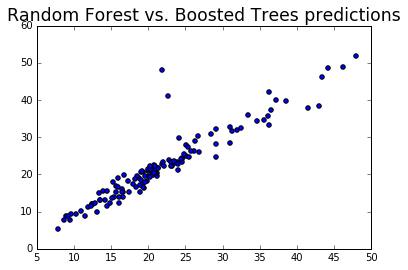

In [38]:
# plot predictions against each other
pyplot.scatter(
    x=rf_test_predictions_ddf.select('predicted_medv').rdd.collect(),
    y=gbt_test_predictions_ddf.select('predicted_medv').rdd.collect())

pyplot.title('Random Forest vs. Boosted Trees predictions')

## Evaluate models

In [39]:
rf_rmse = \
    regression_evaluator.evaluate(
        dataset=rf_test_predictions_ddf)
    
rf_rmse

3.227049077856861

In [40]:
gbt_rmse = \
    regression_evaluator.evaluate(
        dataset=gbt_test_predictions_ddf)
    
gbt_rmse

4.52946097127153